In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from particles import kalman
from scipy.optimize import minimize


# Question 1 State Space Modeling for River Nile

In [2]:
# Q1. read the csv
nile = pd.read_csv("nile.csv")
nile["years"] = range(1871, 1971)
nile.head(10)

,flow,years
0,1120,1871
1,1160,1872
2,963,1873
3,1210,1874
4,1160,1875
5,1160,1876
6,813,1877
7,1230,1878
8,1370,1879
9,1140,1880


In [3]:
# Q2. Split into train and test set
TRAIN_SIZE = 80
train_df = nile[:TRAIN_SIZE]
test_df = nile[TRAIN_SIZE:]
train_df.shape, test_df.shape

((80, 2), (20, 2))

In [4]:
# Q3. Identify the changepoint
mean_before = nile[nile["years"] <= 1898]["flow"].mean()
mean_after = nile[nile["years"] > 1898]["flow"].mean()
mean_before, mean_after # From the mean value before year 1898 and after year 1898, we can clearly see a significant difference

(1097.75, 849.9722222222222)

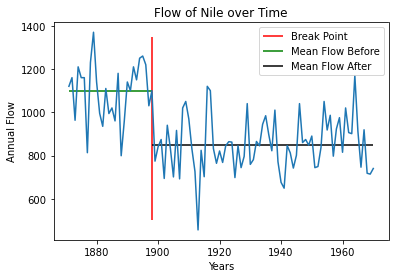

In [5]:
plt.plot(nile.years, nile.flow)
plt.vlines(x=1898, ymin=500, ymax=1350, color="red", label="Break Point")
plt.hlines(y=mean_before, xmin=1871, xmax=1898, color="green", label="Mean Flow Before")
plt.hlines(y=mean_after, xmin=1898, xmax=1970, color="black", label="Mean Flow After")
plt.xlabel("Years")
plt.ylabel("Annual Flow")
plt.title("Flow of Nile over Time")
plt.legend()
plt.show()

In [6]:
# Q4.Construct a state space model
def build_model(varX, varY):
    ssm = kalman.MVLinearGauss(F=np.eye(1), G=np.eye(1),
                               covX=np.array([varX]), covY=np.array([varY]),
                               mu0=np.array([1120]), cov0=np.array([1450]))
    return ssm

In [7]:
# Q5.Construct a kalman filter
def compute_log_likelihood(theta):
    varX = theta[0]
    varY = theta[1]

    ssm = build_model(varX, varY)
    kf = kalman.Kalman(ssm=ssm, data=train_df.flow.to_numpy())
    kf.filter()
    log_likelihood = np.sum(kf.logpyt)
    return log_likelihood

In [10]:
# Q6. Compute the maximum likelihood estimator
theta0 = [1450, 15000]
output = minimize(lambda theta: -compute_log_likelihood(theta),
                  x0=theta0, method="Nelder-Mead")
mle = output.x
mle

array([ 1438.04517468, 16003.77131545])

In [11]:
# Q7. Perform Kalman filtering and smoothing on the state space model
ssm_mle = build_model(mle[0], mle[1])
kf_mle = kalman.Kalman(ssm=ssm_mle, data=train_df.flow.to_numpy())
kf_mle.filter()
kf_mle.smoother()

In [12]:
# Q8. Plot the filtering mean and smoothing mean
filter_means = np.array([filtering.mean[0] for filtering in kf_mle.filt])
filter_stds = np.array([np.sqrt(filtering.cov[0,0]) for filtering in kf_mle.filt])
smooth_means = np.array([smoothing.mean[0] for smoothing in kf_mle.smth])
smooth_stds = np.array([np.sqrt(smoothing.cov[0, 0]) for smoothing in kf_mle.smth])

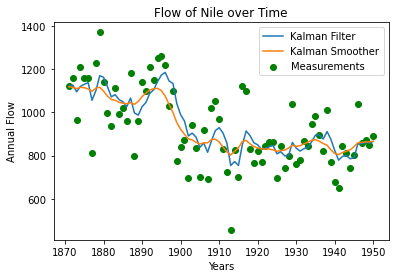

In [13]:
plt.plot(train_df.years, filter_means, label="Kalman Filter")
plt.plot(train_df.years, smooth_means, label="Kalman Smoother")
plt.scatter(train_df.years, train_df.flow, label="Measurements", color="green")
plt.xlabel("Years")
plt.ylabel("Annual Flow")
plt.title("Flow of Nile over Time")
plt.legend()
plt.show()

Since smoother uses more information (the entire time series) than filter, which only uses historical points, it appears more smooth with less variations as more information we collect, more certain we are about estimations.

As to the change point, since smoother considers both preceding and following data points, it will reflect the drop earlier than the filter to extrapolate the trend.

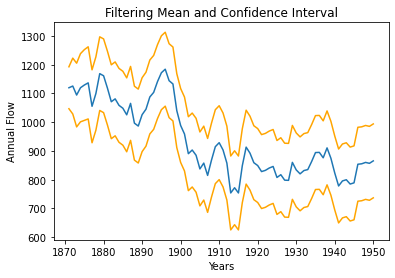

In [14]:
plt.plot(train_df.years, filter_means)
plt.plot(train_df.years, filter_means - 2*filter_stds, color = "orange")
plt.plot(train_df.years, filter_means + 2*filter_stds, color = "orange")
plt.xlabel("Years")
plt.ylabel("Annual Flow")
plt.title("Filtering Mean and Confidence Interval")
plt.show()

In [ ]:
plt.plot(train_df.years, smooth_means)
plt.plot(train_df.years, smooth_means - 2*smooth_stds, color = "orange")
plt.plot(train_df.years, smooth_means + 2*smooth_stds, color = "orange")
plt.xlabel("Years")
plt.ylabel("Annual Flow")
plt.title("Filtering Mean and Confidence Interval")
plt.show()

In [ ]:
np.sum(smooth_stds <= filter_stds)
# smoothing standard deviations are smaller for all observations

In [ ]:
smooth_stds <= filter_stds